### Image Classification with Tensorflow and AzureML

#### Create a Handle to the Workspace

In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# authenticate
credential = DefaultAzureCredential()
# # Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="",  # this will look like xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx
    resource_group_name="",
    workspace_name="",
)

#### Register Data

In [2]:
import numpy as np

In [3]:
# load mnist data

def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data('data/mnist.npz')

In [4]:
# train size
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [5]:
# test size
x_test.shape, y_train.shape

((10000, 28, 28), (60000,))

**Visualize Data**

In [6]:
# visualize mnist data
import matplotlib.pyplot as plt

In [7]:
# take sample data
sample_idx = np.random.randint(1000, size=20)
#sample_idx

sample_data = x_train[sample_idx,:]

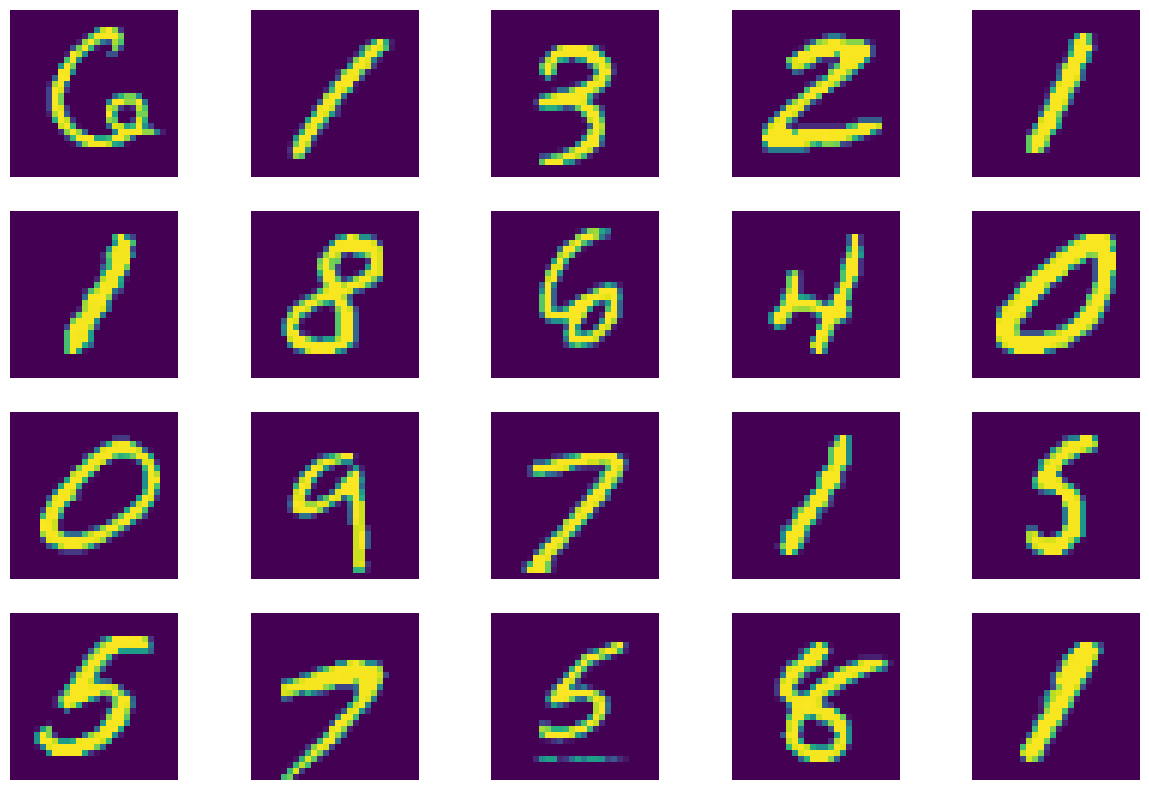

In [8]:
fig, ax = plt.subplots(4, 5, figsize = (15, 10))
ax = ax.ravel()

for i, arr in enumerate(sample_data):
    arr = np.expand_dims(arr,-1)
    ax[i].imshow(arr)
    ax[i].axis('off')

In [9]:
# register data
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

data_path = "data/mnist.npz"

try:
    registered_data_asset = ml_client.data.get(name="mnist", version="1")
    print("Found data asset. Will not create again")
except Exception as ex:
    my_data = Data(
        path=data_path,
        type=AssetTypes.URI_FILE,
        description="Mnist Data",
        name="mnist",
        version="1",
    )
    ml_client.data.create_or_update(my_data)
    
    registered_data_asset = ml_client.data.get(name="mnist", version="1")
    print("Created data asset")



Found data asset. Will not create again


In [10]:
registered_data_asset.path

'azureml://subscriptions/3f5e04ab-2448-47b6-b4ec-4720cbde8c43/resourcegroups/ML-pipeline/workspaces/ML-pipeline/datastores/workspaceblobstore/paths/LocalUpload/7e36c7e0386e2d9f06457b4c8698ec39/mnist.npz'

#### Create compute cluster

In [11]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure Machine Learning compute object with the intended parameters
    # if you run into an out of quota error, change the size to a comparable VM that is available.
    # Learn more on https://azure.microsoft.com/en-us/pricing/details/machine-learning/.
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure Machine Learning Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_DS3_V2",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=4,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )
    print(
        f"AMLCompute with name {cpu_cluster.name} will be created, with compute size {cpu_cluster.size}"
    )
    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster)

Creating a new cpu compute target...
AMLCompute with name cpu-cluster will be created, with compute size STANDARD_DS3_V2


#### Data Preparation component

In [12]:
import os

data_prep_src_dir = "./tensorflow/components/data_prep"
os.makedirs(data_prep_src_dir, exist_ok=True)

In [13]:
%%writefile {data_prep_src_dir}/data_prep.py
import os
import argparse
import numpy as np
import mlflow
from sklearn.model_selection import train_test_split

def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--train_val_ratio", type=float, help="train test ratio for split", default = 0.25, required=False)
    parser.add_argument("--partition_data", type=str, help="path to store data after partition")
    #parser.add_argument("--val_data", type=str, help="path to store validation data")
    #parser.add_argument("--test_data", type=str, help="path to test data")

    args = parser.parse_args()

    with mlflow.start_run():

        (x_train, y_train), (x_test, y_test) = load_data(args.data)
        print(x_train.shape, y_train.shape)
        print(x_test.shape, y_test.shape)

        mlflow.log_metric("raw_train_samples", x_train.shape[0])
        mlflow.log_metric("raw_test_samples", x_test.shape[0])

        # make train and validation splits
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=args.train_val_ratio)
        print(x_train.shape, y_train.shape)
        print(x_val.shape, y_val.shape)

        mlflow.log_metric("train_samples", x_train.shape[0])
        mlflow.log_metric("val_samples", x_val.shape[0])

        # save the data
        np.savez(os.path.join(args.partition_data, "data.npz"), 
                x_train = x_train, y_train = y_train,
                x_val = x_val, y_val = y_val,
                x_test = x_test, y_test = y_test)
       
        #np.savez(os.path.join(args.val_data, "data.npz"), x_val = x_val, y_val = y_val)
        #np.savez(os.path.join(args.test_data, "data.npz"), x_test = x_test, y_test = y_test)


if __name__ == "__main__":
    main()

Overwriting ./tensorflow/components/data_prep/data_prep.py


In [20]:
from azure.ai.ml import command
from azure.ai.ml import Input, Output

data_prep_mnist = command(
    name="data_prep_mnist",
    display_name="Data preparation for training",
    description="read mnist data and create train, val, test sets",
    inputs = {
        "data": Input(type="uri_file", mode = 'ro_mount'),
        #"ratio": Input(type = "number", default = 0.25),
    },

     outputs={
        "partition_data":  Output(type="uri_folder", mode="rw_mount")
        #"train_data": Output(type="uri_folder", mode="rw_mount"),
        #"val_data": Output(type = "uri_folder", mode = "rw_mount"),
        #"test_data": Output(type="uri_folder", mode="rw_mount")
     },

    
    # The source folder of the component
    code = data_prep_src_dir,
    command = """python data_prep.py \
            --data ${{inputs.data}} \
            --train_val_ratio 0.25\
            --partition_data ${{outputs.partition_data}}

            """,
    environment= "azureml://registries/azureml/environments/sklearn-1.1/versions/4",
    #compute=cpu_compute_target
)


In [21]:
# register the data prep component
data_prep_mnist_component = ml_client.create_or_update(data_prep_mnist.component)

print(
    f"Component {data_prep_mnist_component.name} with Version {data_prep_mnist_component.version} is registered"
)

Component data_prep_mnist with Version 2023-10-10-08-10-02-3020572 is registered


#### Training Component

In [17]:
import os

train_src_dir = "./tensorflow/components/train"
os.makedirs(train_src_dir, exist_ok=True)

In [18]:
%%writefile {train_src_dir}/train.py
import argparse
import os
import pandas as pd
import numpy as np
import mlflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam


def load_data(folder_path):
    """Selects first file in folder, use under assumption there is only one file in folder"""
    files = os.listdir(folder_path)
    file_path = os.path.join(folder_path, files[0])
    with np.load(file_path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_val, y_val     = f['x_val'], f['y_val']
        x_test, y_test   = f['x_test'], f['y_test']

        return (x_train, y_train), (x_val, y_val), (x_test, y_test)
    

def train_model(x_train, y_train, x_val, y_val, epochs=1, lr_rate = 0.003):
    
    model = Sequential()
    
    model.add(Reshape((28,28,1), input_shape = (28,28)))
    
    model.add(Conv2D(64, (5, 5),
                      padding="same",
                      activation="relu",
                      input_shape=(28, 28, 1)))
     
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5), padding="same",
                      activation="relu"))
     
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (5, 5), padding="same",
                      activation="relu"))
     
    model.add(MaxPooling2D(pool_size=(2, 2)))
     
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.4))
     
    model.add(Dense(10, activation="softmax"))
    

    model.compile(optimizer=Adam(learning_rate = lr_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    model.fit(x_train, y_train, 
              validation_data = (x_val, y_val),
              batch_size = 64,
              epochs=epochs)

    return model


def evaluate(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test)
    return (loss, acc)


def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to data")
    parser.add_argument("--epochs", required=False, default=20, type=int)
    parser.add_argument("--learning_rate", required=False, default=0.003, type=float)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    parser.add_argument("--model", type=str, help="path to model file")

    args = parser.parse_args()


    with mlflow.start_run():

        mlflow.tensorflow.autolog(log_models = False)

        # load_data
        (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data(folder_path= args.data)

        # train model
        model = train_model(x_train = x_train, y_train = y_train,
                            x_val = x_val, y_val = y_val,
                            epochs = args.epochs,
                            lr_rate = args.learning_rate)
        
        loss, acc = evaluate(model = model, x_test=x_test, y_test=y_test) 

        mlflow.log_metrics({'loss': loss,
                            "accuracy":acc})

        # Registering the model to the workspace
        print("Registering the model via MLFlow")
        mlflow.tensorflow.log_model(
            model=model,        
            registered_model_name=args.registered_model_name,
            artifact_path=args.registered_model_name,
        )

        # Saving the model to a file
        mlflow.tensorflow.save_model(
            model = model,
            path = os.path.join(args.model, "mnist_model"),
        )

if __name__ == "__main__":
    main()


Overwriting ./tensorflow/components/train/train.py


In [19]:
# training component
from azure.ai.ml import command
from azure.ai.ml import Input, Output

data_folder = ml_client.data.get("azureml_data_prep_mnist_9_output_data_partition_data", version = 1)

train_mnist = command(
    name="train_mnist",
    display_name="Training Mnist",
    description="Training Mnist classification",
    inputs = {
        "data": Input(type="uri_folder", path = data_folder.path, mode = 'ro_mount'),
        #"registered_model_name": Input(type = "string", default = "mnist_keras_model"),
    },

     outputs={
        "model":  Output(type="uri_folder", mode="rw_mount")
     },

    
    # The source folder of the component
    code = train_src_dir,
    command = """python train.py \
            --data ${{inputs.data}} \
            --epochs 5 \
            --learning_rate 0.001\
            --registered_model_name "mnist_model"\
            --model ${{outputs.model}}

            """,
    environment= "azureml://registries/azureml/environments/tensorflow-2.12-cuda11/versions/12",
    #compute=cpu_compute_target
)

In [22]:
# register the train component
mnist_train_component = ml_client.create_or_update(train_mnist.component)
print(
    f"Component {mnist_train_component.name} with Version {mnist_train_component.version} is registered"
)


Component train_mnist with Version 1 is registered


#### Pipeline

In [23]:
from azure.ai.ml import dsl, Input, Output

In [27]:
@dsl.pipeline(
    compute = cpu_compute_target,
    description = "ml pipeline to train mnist classification with tensorflow",
    #experiment_name = "mnist_pipeline"
)

def mnist_tensorflow_pipeline(
    pipeline_job_input_data):

    # use data prep component
    data_prep_job = data_prep_mnist_component(
        data = pipeline_job_input_data
    )

    # use train component
    train_job = mnist_train_component(
        data = data_prep_job.outputs.partition_data
    )

    return {
        "pipeline_job_train_data": data_prep_job.outputs.partition_data,
        "pipeline_job_model": train_job.outputs.model,
    }   


In [28]:
# Let's instantiate the pipeline with the parameters of our choice
pipeline = mnist_tensorflow_pipeline(
    pipeline_job_input_data = Input(type="uri_file", path=registered_data_asset.path)
    )

In [ ]:
# submit the job
pipeline_job = ml_client.jobs.create_or_update(
    job = pipeline,
    experiment_name = "mnist tensorflow pipeline"
)

ml_client.jobs.stream(pipeline_job.name)